# CIA Factbook Data Using SQLite in Python

#### We will be using SQLite3 to query the CIA Factbook database and do some basic data analysis

In [79]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [34]:
# creating a connection to the factbook db which has data for 2015
conn = sqlite3.connect('factbook.db')

In [35]:
# here we are creating a query that will result in a list of all tables in the database
q1 = "SELECT * FROM sqlite_master WHERE type = 'table';"

In [36]:
# reading in data using pandas read_sql_query
pd.read_sql_query(q1, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."
2,table,cities,cities,2,CREATE TABLE cities (\n id integer prim...


In [37]:
# returing first five records of the facts table
q2 = "Select * FROM facts;"
df = pd.read_sql_query(q2, conn)
df.head()

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230.0,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51
1,2,al,Albania,28748.0,27398.0,1350.0,3029278.0,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741.0,2381741.0,0.0,39542166.0,1.84,23.67,4.31,0.92
3,4,an,Andorra,468.0,468.0,0.0,85580.0,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700.0,1246700.0,0.0,19625353.0,2.78,38.78,11.49,0.46


In [38]:
# creating some simple summary statistics using pandas
min_pop = df['population'].min()
max_pop = df['population'].max()
min_growth = df['population_growth'].min()
max_growth = df['population_growth'].max()

In [39]:
print('min pop: ', min_pop, '  max pop: ', max_pop, '  min pop growth: ', min_growth, '  max pop growth: ', max_growth)

min pop:  0.0   max pop:  7256490011.0   min pop growth:  0.0   max pop growth:  4.02


In [55]:
# creating a query for simple summary statistics using SQL
q3 = """SELECT MIN(population) min_population
,MAX(population) max_population
,MIN(population_growth) max_pop_growth
,MAX(population_growth) min_pop_growth
FROM facts;
"""

In [56]:
summary_stats = pd.read_sql_query(q3, conn)
summary_stats

   min_population  max_population  max_pop_growth  min_pop_growth
0               0      7256490011             0.0            4.02


In [66]:
# there is a country with a population of zero which is odd and one with 7 billion, we will now return the country name
q4 = """
SELECT name country
,population
FROM facts
WHERE population = 0
OR population = 7256490011
"""

In [67]:
# the values with the min and max are Antartica and the World
min_max_pop = pd.read_sql_query(q4, conn)
min_max_pop

,country,population
0,Antarctica,0
1,World,7256490011


In [127]:
# query without those two outliers
q5 = """
SELECT name country
,population
,population_growth
,birth_rate
,death_rate
FROM facts
WHERE population != (SELECT MIN(population) FROM facts)
OR population != (SELECT MAX(population) FROM facts)"""

In [128]:
clean_df = pd.read_sql_query(q5, conn)
clean_df.head()

,country,population,population_growth,birth_rate,death_rate
0,Afghanistan,32564342,2.32,38.57,13.89
1,Albania,3029278,0.30,12.92,6.58
2,Algeria,39542166,1.84,23.67,4.31
3,Andorra,85580,0.12,8.13,6.96
4,Angola,19625353,2.78,38.78,11.49


In [96]:
# we have some null fields we want to replace with zeros
clean_df.isnull().any()

country              False
population           False
population_growth     True
birth_rate            True
death_rate            True
dtype: bool

In [98]:
clean_df = clean_df.fillna(0)

## Plotting some of the data in histograms using matplotlib pyplot

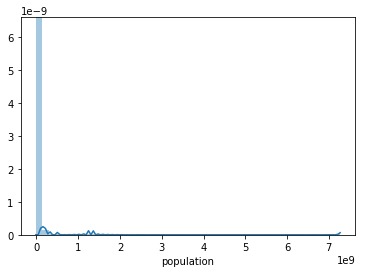

In [101]:
distribution of population
sns.distplot(clean_df['population'])

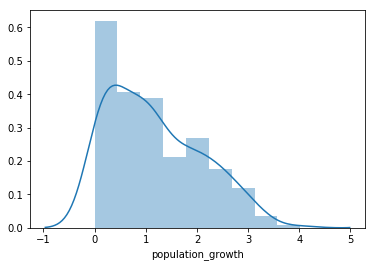

In [104]:
# distribution of population growth
sns.distplot(clean_df['population_growth'])

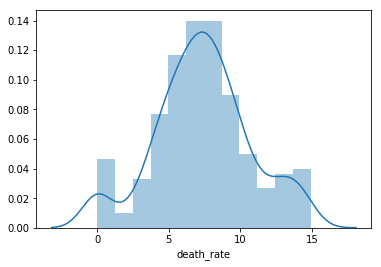

In [106]:
# distribution of death rate
sns.distplot(clean_df['death_rate'])

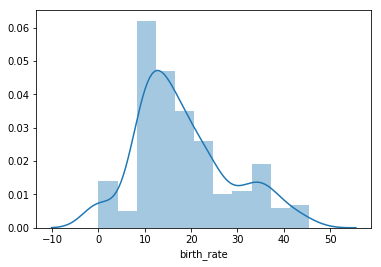

In [109]:
# distribution of birth rate
sns.distplot(clean_df['birth_rate'])

In [125]:
# generating some calculations for population density
# population density is ratio of population to land area
q6 = """
SELECT CAST(population AS float)/CAST(area_land AS float) pop_density
,population
,area_land
,name country
FROM facts
WHERE population != (SELECT MIN(population) FROM facts)
OR population != (SELECT MAX(population) FROM facts)
ORDER BY 1 DESC
"""

In [126]:
pop_density = pd.read_sql_query(q6, conn)
pop_density.head()

,pop_density,population,area_land,country
0,21168.964286,592731,28.0,Macau
1,15267.500000,30535,2.0,Monaco
2,8259.784571,5674472,687.0,Singapore
3,6655.271202,7141106,1073.0,Hong Kong
4,5191.819444,1869055,360.0,Gaza Strip


In [120]:
top_10_dens = pop_density.head(10)

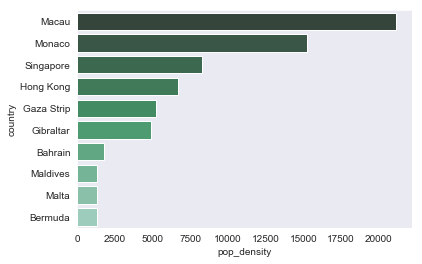

In [140]:
sns.set_style('dark')
sns.barplot(x='pop_density', y='country', data=top_10_dens, palette='BuGn_d')